### CS166 Assignment 3

## Network Simulation

_Dennis Kageni, April 2020_

-------------------------------

The goal of this assignment is to implement improvements to the social dynamics model on adaptive networks and analyze the expected (theoretical) and actual (experimental) effects of the proposed improvements.

# The basic model
The social dynamics model explores the interaction between people’s preferences or opinions and the strength of their social connections. The basic idea is that social dynamics are driven by two factors:

1. People prefer forming social relationships with others who share their preferences, opinions or interests.
2. People’s preferences, opinions or interests tend to become similar to those of other people in their social circle.

These processes are then modeled on a small-world network (Watts-Strogatz graph) to observe how both opinions and relationships change over time.

We use **nodes** to represent each person in the network; where each node is associated with an opinion attribute that is represented as a floating-point number between 0 and 1. People with similar values for their opinion are in agreement on the topic and people with very different values disagree strongly. For example, given a node with opinion 0.3, and a different node with opinion 0.8, the nodes will have an opinion difference of |0.3-0.8| = 0.5.

On the other hand, **edges** represent the existence of a social relationship between two nodes in the network. Each edge has an associated weight that’s also represented as a floating-point number between 0 and 1 (weights lower than 0.05 are considered severed edges). A weight close to 0 means that the relationship between two people is weak and that those two people’s opinions do not influence each other much. A weight close to 1 means that two people have a very strong relationship and will tend to adjust their opinions to be closer to each other. For example, two nodes with an edge of w = 0.9 between them have a stronger relationship than two nodes with an edge of w = 0.2 between them.

A random edge is then chosen asynchronously at each timestep. The associated nodes' opinion and weight attributes are then updated, simulating an interaction between the individuals.

## Update Rules 
There are 3 update rules that dictate the evolution of the social network's dynamics:

### Rule 1: People change opinions to more closely match those of people they have a strong relationship with. 
We model this by selecting a random edge from the network — that is, two people who have an existing social relationship — and letting them interact. We then update the opinion of each person to move a bit closer together. The stronger their relationship, the more they will move their opinions closer to each other.

The change in opinion of Person $i$ when talking to Person $j$ is

$$\Delta o_i = \alpha w_{ij}(o_j-o_i)$$

Person $j$’s opinion also changes, but in the opposite direction to Person $i$’s, thus bringing their opinions closer together. 

$\alpha \in (0,0.5]$ (flexibility level)

* High $\alpha$ indicates high flexibility: people change their opinions to match other people's relatively quickly.
* Low $\alpha$ indicates inflexibility, people change their opinions to match other people's relatively slowly.

### Rule 2: People strengthen or weaken their relationships depending on whether they agree or disagree, respectively. 
During the same interaction as in Step 1, the weight of the edge connecting nodes $i$ and $j$ is also changed. The update in edge weight symbolizes the strengthening or weakening of the internode relationship depending on how similar or dissimilar their opinions were. 

The change in weight between Person $i$ and Person $j$:

$$\Delta w_{ij} = \beta w_{ij}(1-w_{ij})(1-\gamma |o_i-o_j|)$$

$\beta \in (0,1)$ (Relationship rate change)

* High $\beta$ indicates that relationships change drastically in response to a difference in opinion.
* Low $\beta$ indicates that relationships do not change much in response to a difference in opinion

$\gamma > 0$ (Sensitivity to different opinions)

*  $\gamma \leq 1$ indicates low sensitivity. All edge weights will converge to 1 over time since different opinions don't matter enough to decrease edge weights.
*  $\gamma > 1$ indicates middle to high sensitivity. The edge weight between two nodes will decrease if the opinions of the nodes are different enough, i.e. if $|o_i - o_j| > \gamma^{-1}$.

As a final step when updating weights, we remove an edge from the network if its weight drops below 0.05. This step models a social relationship that has broken down.

### Rule 3: New social connections are formed between random people who are not yet connected.
This is a relatively rare occurrence, so we do Steps 1 and 2 above 99% of the time and Step 3 only 1% of the time. Think of this process as randomly meeting someone new and forming a friendship with them. The edge weight is initially set to 0.5 in these cases. Over time the weight will increase towards 1 or decrease towards 0 depending on whether the two people have similar or differing opinions, using Steps 1 and 2.

In this following implementation, we will be using the following parameter values:
$\alpha$ = 0.03, $\beta$ = 0.3, $\gamma$ = 4 


In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set()

random.seed(123) # for reproducability

In [2]:
# https://gist.github.com/cscheffler/f8f8416513356e184e9568fa69c90889
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
            
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
            
            
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

## Discussion 

It is important to note that when analyzing this model, the outcome we're interested in is whether the nodes in the social network merge or split apart. If most or all nodes form a larger interconnected group with similar opinions, then the network has converged. Otherwise, when nodes form two or more groups that are interconnected and share similar opinions but where these groups are not very connected and have different opinions, the network has diverged. The code below shows an example of a convergent and divergent social network.

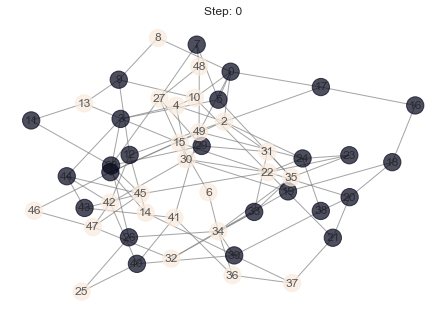

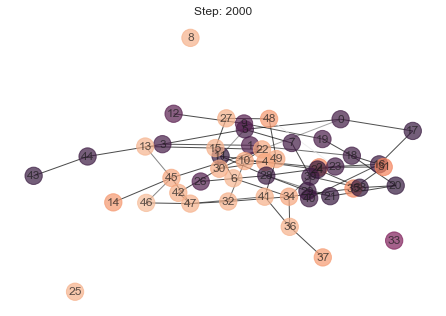

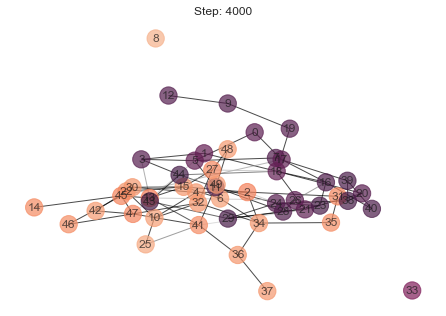

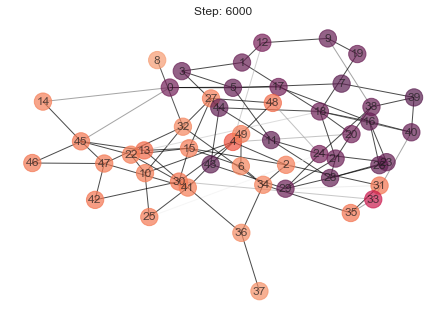

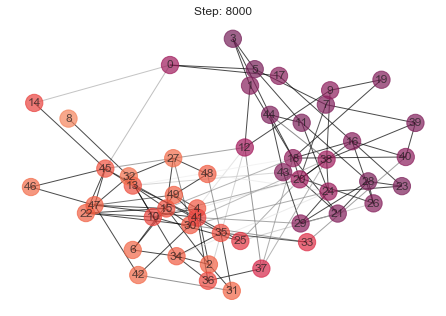

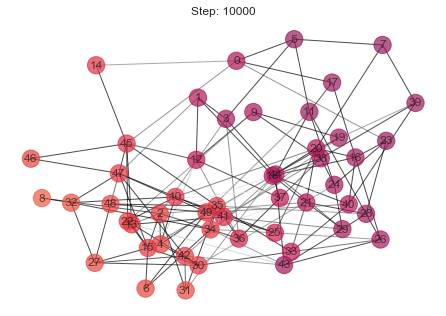

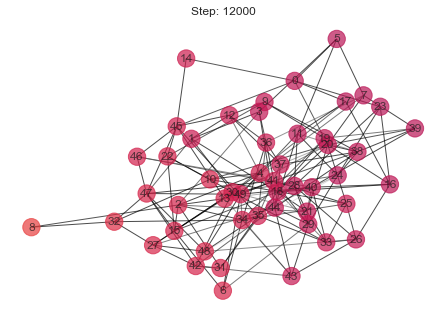

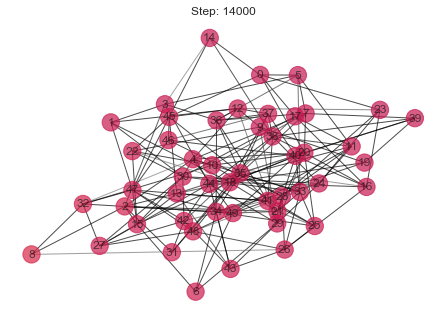

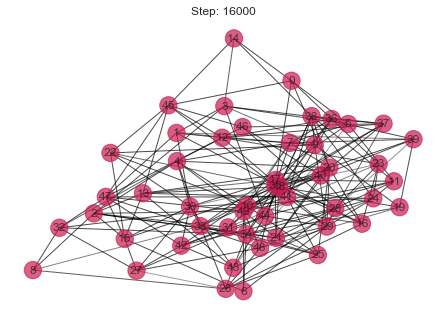

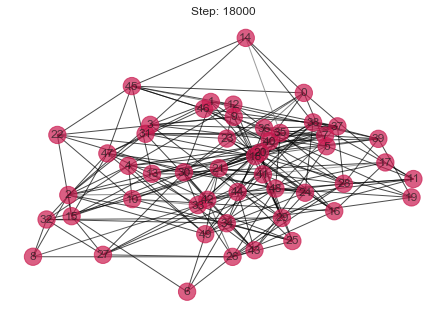

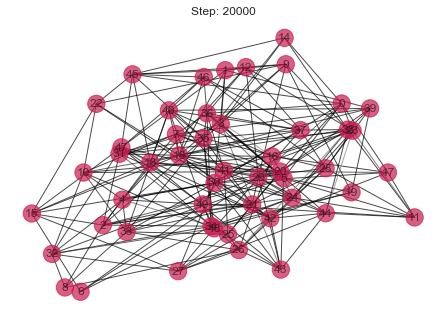

In [3]:
sim_convergence = SocialDynamicsSimulation(alpha = 0.06, beta = 0.2, gamma = 4)
sim_convergence.initialize()
plt.figure()
sim_convergence.observe()
for i in range(10):
    for i in range(2000):
        sim_convergence.update()
    plt.figure()
    sim_convergence.observe()

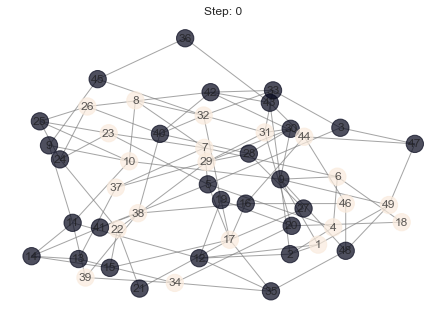

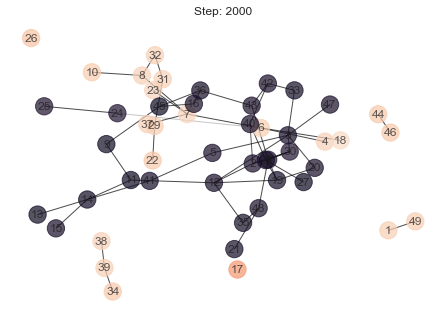

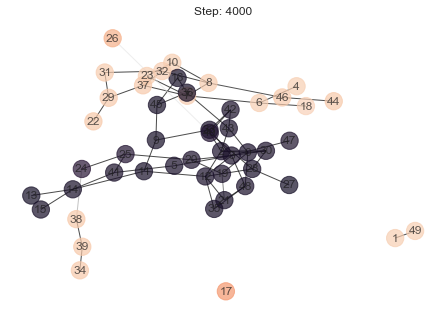

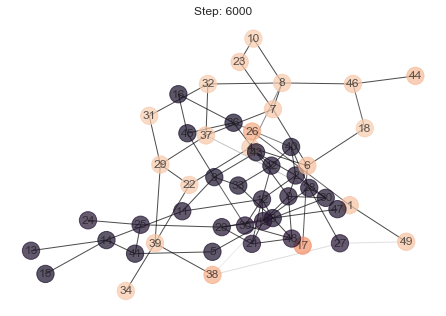

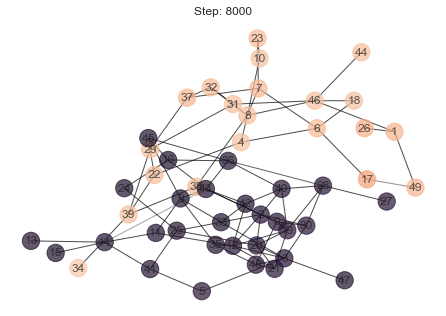

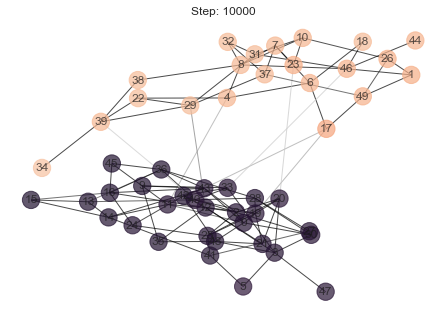

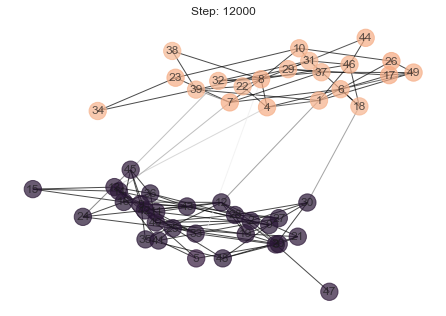

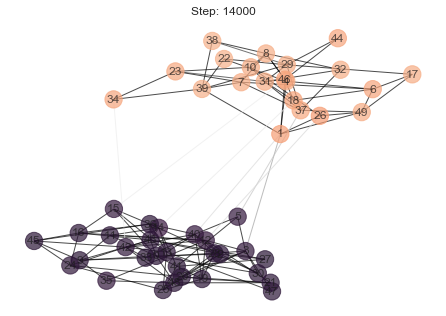

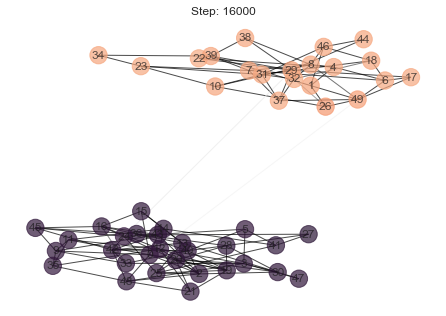

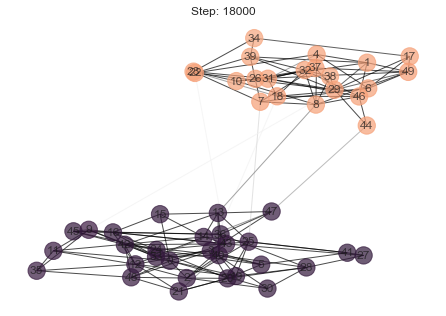

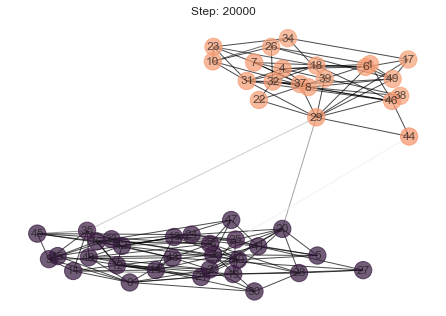

In [4]:
sim_divergence = SocialDynamicsSimulation()
sim_divergence.initialize()
plt.figure()
sim_divergence.observe()
for i in range(10):
    for i in range(2000):
        sim_divergence.update()
    plt.figure()
    sim_divergence.observe()

### 
Since the $\alpha$, $\beta$ and $\gamma$ parameters all determine  if the social network model converges or not, it would be beneficial to define a singular  metric that can help us determine if the network model will converge or diverge. 

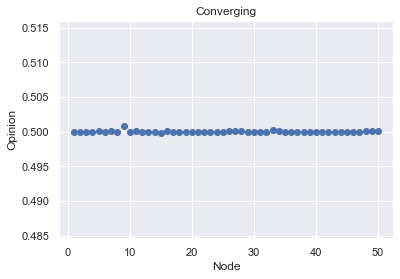

Converging Standard Deviation is : 0.00012274102420422177


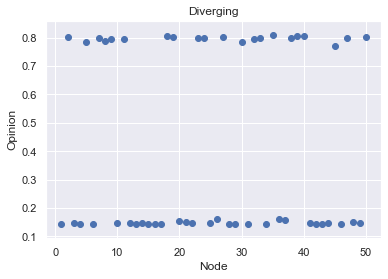

Diverging Standard Deviation is : 0.32119052896571587


In [5]:
def singular_metric(network_sim, title):
    """
    Function that takes the opinion attribute value for each node in
    the network simulation model, plots the resulting scatter plot and
    calculates its standard deviation
    
    """
    opinion_vals = []
    for i in list(network_sim.graph.nodes()):
        opinion_vals.append(network_sim.graph.nodes[i]['opinion'])
    plt.title(title)
    plt.scatter([x for x in range(1,51)],opinion_vals)
    plt.xlabel("Node")
    plt.ylabel("Opinion")
    plt.show()
    print (title, "Standard Deviation is :",np.std(opinion_vals))

singular_metric(sim_convergence, "Converging")
singular_metric(sim_divergence, "Diverging")

### 
Now that we've established that the standard deviation is a suitable metric, we will proceed to identify a suitable threshold that separates the convergence state from the divergence state

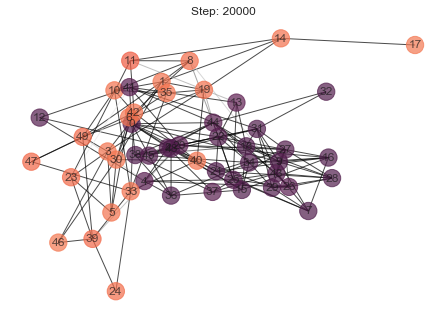

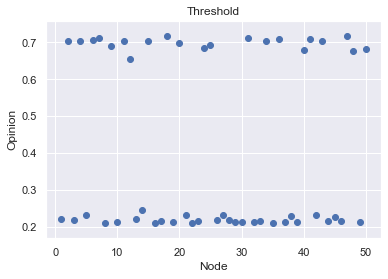

Threshold Standard Deviation is : 0.23703297247317096


In [6]:
sim_threshold = SocialDynamicsSimulation(alpha = 0.06, beta = 0.4, gamma = 4)
sim_threshold.initialize()
for i in range(4):
    for i in range(5000):
        sim_threshold.update()
plt.figure()
sim_threshold.observe()

plt.figure()
singular_metric(sim_threshold, "Threshold")

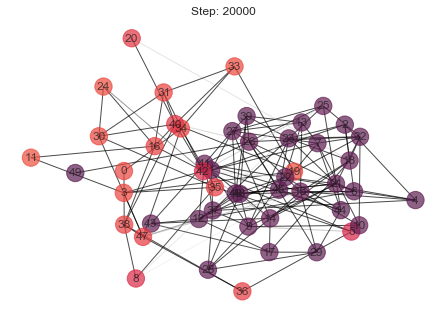

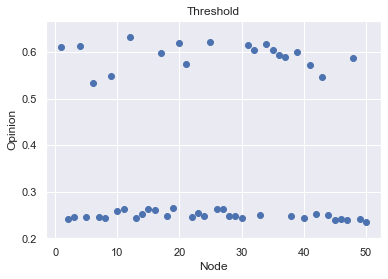

Threshold Standard Deviation is : 0.16798925716973032


In [7]:
sim_threshold = SocialDynamicsSimulation(alpha = 0.065, beta = 0.4, gamma = 4)
sim_threshold.initialize()
for i in range(4):
    for i in range(5000):
        sim_threshold.update()
plt.figure()
sim_threshold.observe()

plt.figure()
singular_metric(sim_threshold, "Threshold")

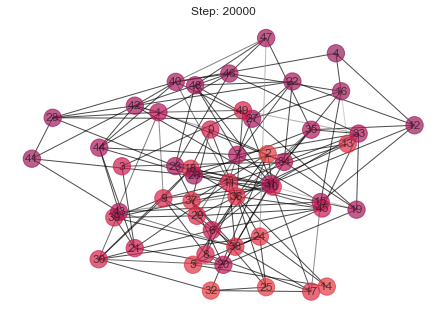

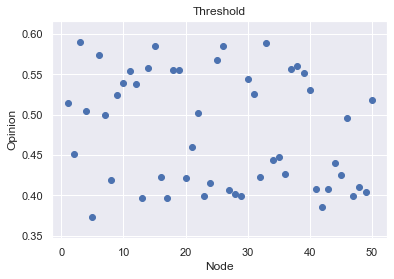

Threshold Standard Deviation is : 0.06935523217639179


In [8]:
sim_threshold = SocialDynamicsSimulation(alpha = 0.07, beta = 0.4, gamma = 4)
sim_threshold.initialize()
for i in range(4):
    for i in range(5000):
        sim_threshold.update()
plt.figure()
sim_threshold.observe()

plt.figure()
singular_metric(sim_threshold, "Threshold")

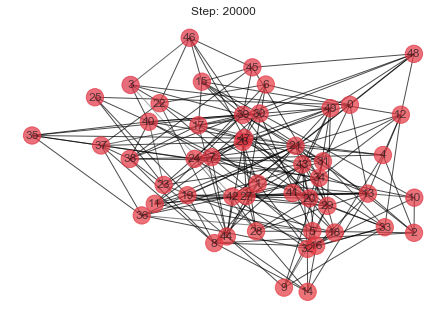

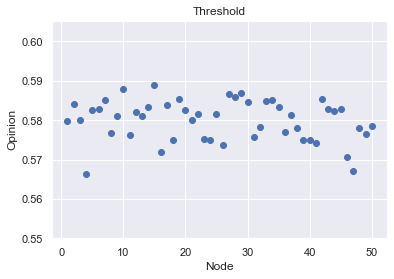

Threshold Standard Deviation is : 0.005130473185399916


In [9]:
sim_threshold = SocialDynamicsSimulation(alpha = 0.075, beta = 0.4, gamma = 4)
sim_threshold.initialize()
for i in range(4):
    for i in range(5000):
        sim_threshold.update()
plt.figure()
sim_threshold.observe()

plt.figure()
singular_metric(sim_threshold, "Threshold")

###
We can set the threshold at a standard deviation value of 0.05. Therefore, any social network that has a standard deviation value that is greater than 0.05 is divergent. Otherwise, it is convergent.

The next step is to analyse how changes in $\alpha$, $\beta$ and $\gamma$ affect the network simulation results

In [10]:
alpha_vals = np.linspace(0.01,.1, 10)
beta_vals = np.linspace(0.05, 0.95, 10)
gamma = 4
sims = 6

def converge_test(alpha, beta, gamma, sims):
    avg_list = []
    for _ in range(sims):
        sim = SocialDynamicsSimulation(alpha = alpha, beta = beta, gamma = gamma)
        sim.initialize()
        for i in range(20000):
            sim.update()
        lis = []
        for i in list(sim.graph.nodes()):
            lis.append(sim.graph.nodes[i]['opinion'])
        std = (np.std(lis))
        if std >= 0.05:
            avg_list.append(0)
        else:
            avg_list.append(1)
    if sum(avg_list) >= np.floor(sims/2.0):
        return (1)
    else:
        return (0)

results = []
for alpha in alpha_vals:
    for beta in beta_vals:
        results.append(converge_test(alpha, beta, gamma, sims))
#     print (alpha, "complete")

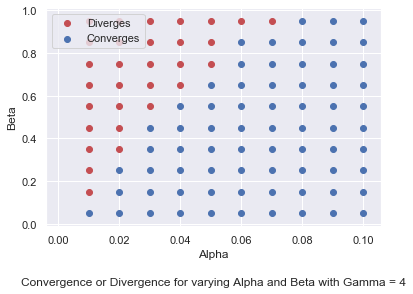

In [11]:
alpha_arr = np.array(alpha_vals)
beta_arr = np.array (beta_vals)

mat = np.meshgrid(alpha_arr, beta_arr)
mat_conv = [[],[]]
mat_div = [[],[]]

for i in range(10):
    for j in range(10):
        if results[10*i + j] == 1:
            mat_conv[0].append(mat[0][i][j])
            mat_conv[1].append(mat[1][i][j])
        else:
            mat_div[0].append(mat[0][i][j])
            mat_div[1].append(mat[1][i][j])


plt.title("Convergence or Divergence for varying Alpha and Beta with Gamma = 4", y=-0.3)
plt.scatter(mat_conv[0], mat_conv[1], c = 'r', label = "Diverges")
plt.scatter(mat_div[0], mat_div[1], c = 'b', label = "Converges")
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.legend()
plt.show()


In [21]:
alpha = 0.03
beta = 0.3
gamma_vals = np.linspace(0,10,21)

results = []
for gamma in gamma_vals:
    results.append(converge_test(alpha, beta, gamma, sims))

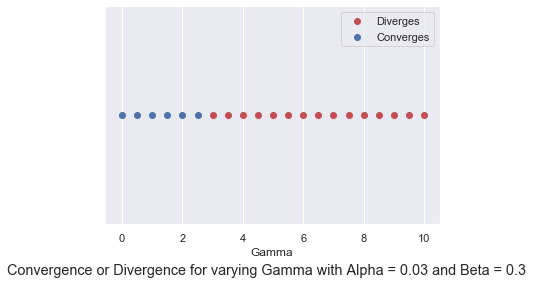

In [13]:
lis_conv = []
lis_div = []

for i in range(21):
    if results[i] == 0:
        lis_div.append(gamma_vals[i])
    else:
        lis_conv.append(gamma_vals[i])

plt.suptitle("Convergence or Divergence for varying Gamma with Alpha = 0.03 and Beta = 0.3", y=-0.01)
plt.scatter(lis_div, [0 for i in lis_div], c = 'r', label = "Diverges")
plt.scatter(lis_conv, [0 for i in lis_conv], c = 'b', label = "Converges")
plt.xlabel("Gamma")
plt.yticks([])
plt.legend()
plt.show()

## Initial Analysis
### Effect of $\alpha$ & $\beta$ when $\gamma$ is held constant
    
Increasing $\alpha$ leads to convergence. This makes sense since when people are inclined to change their opinions based on others' opinions, then the whole network will converge to the dominant opinion. We can also see that reducing $\beta$ leads to convergenece and corroborates the update rules we had discussed above.

### Effect of $\gamma$ when $\alpha$ & $\beta$ are held constant

Increasing $\gamma$ results in diveregence. We can also see that the gamma value of ~3 is the threshold limit when $\alpha$ = 0.03 and $\beta = 0.3$

# Modifications to the Basic Model

## Multiple Opinions

People can share similar opinions on certain topics while differing on others. If they happen to share similar opinions on the chosen topic, then their relationship will be positively affected. If they happen to share dissimilar opinions on the chosen topic, then their relationship will be negatively affected. I implemented three opinions for each node. Kniwing that some opinions are more polarizing (e.g politics, religions) that others, one of the opinions has a high opinion attribute value (0.8), wheras the other two each have an opinion attribute value of 0.1. 

My assumptions are:

1. When people interact, they only discuss one topic, and so only one opinion changes according to the rules of the basic model. 
2. When people strongly disagree, they have an argument after which their opinion become less radical, and their social connection is getting weaker. 
3. People with similar views have a lovely conversation which strengthens their relationship and doesn’t have a significant effect on the opinion itself.

## Forming New Relationships

I establish new relationship in accordance to the following rules:

1. With a probability prob_new, find two nodes that are not connected.
2. Check for the mutual connections. Nodes that have friends in common are more likely to meet, so they'll definitely form a connection.
3. The weight of their edge is determined as the average of the weights of all mutualconnections. If let’s say, they have two friends in common one of which has the weights of 0.7 and 0.6 while the other 0.5 and 0.4 with node 1 and node respectively, the resulting edge will have a weight of 0.55.
4. If these people don't have any mutual connections, the probability of their meeting decreases to 0.1 * prob_new. The weight is chosen randomly from the uniform distribution in the range from 0.3 to 0.7. This range assures that we have some variety but doesn’t allow for radical relationships. The initial weights are also designed to be in this range.


## Model Persuasiveness

Some people are more charismatic or convincing than others, and can therefore influence opinions and relationship strengths more than others. A persuasiveness parameter is included to observe the effects on the model's dynamics; and is drawn from a normal distribution. Most people have their persuasiveness parameter value at 0.5 but our model allows for extremes on both ends of the normal distribution. In the update function, after the change in the opinion has been calculated, it is further modified according to one’s persuasiveness. In case it’s very high (around 1), the opinion can be further modified by up to 0.1 of the change calculated. In case an opponent has negative persuasiveness, the difference in the opinion decreases.

## Justification of Modifications
    
The following modifications constitute major improvements since they present more realistic situations. For example, the rules described in the new relationships parameter are representative of the phrase "tell me who your friend and I’ll tell you who you are". Naturally, we are more likely to make new friends from the extended network of our existing friends. In rare cases, however, we also tend to meet someone outside our regular social circles. The persuasion parameter represent the fact that more charismatic people tend to have larger social networks compares to less charismatic people. Lastly, human beings hold multiple opinions and how each opinion matters to them varies

## Parameters and Update Rules for modified Model
These are identical to the parameters in the original model, except we now add new relationship (prob_new) parameter:

1. Network Size: Represents the number of nodes in the network
2. Alpha: This is the rate at which nodes adjust their opinions to match neighboring nodes' opinions during interactions.
3. Beta: The rate at which edge weights are changed in response to differing opinions.
4. Gamma: The pickiness of nodes. Nodes with opinions differing by more than 1/gamma will result in an edge weight decreasing.
4. New Relationships: The probability of forming a new edge during each update.

### Update Rules
The “update” method consists of two parts. The first part adds new connections as described in the “New Relationships” section above. The other part updates the opinions and edges based on the interaction. It first chooses one edge and the topic (one of the opinions) randomly. Then it recalculates the opinions based on the input parameters and adjusts it based on person’s persuasiveness. After that, the worldview and the edge weight are being updated. Finally, the model removes weak edges which have the value of less than 0.05.

# Local analysis

## Relationship between Two People

Opinion change follows the following rule: $$ \Delta o_{i}=\alpha w_{i j}\left(o_{j}-o_{i}\right) $$

When two people interact, their opinions become more similar. In case the opinion has a higher value, the change in the opinion will be negative, and so the value will decrease. Otherwise, the change will be positive.

A new opinion is formed based on one’s persuasiveness $(p)$: $$o_{i}^{\prime}=o_{i}+\Delta o_{i}+0.1 p_{j} \Delta o_{i}$$

If one’s opponent is very persuasive, the change in the opinion can be raised up to 110%, and so different views will diverge faster. However, it is still not the end of the interaction, since this single opinion only has a limited effect on the worldview (wv) which is illustrated on the vector graph: $$wv=0.8 * o_{1}+0.1 * o_{2}+0.1 * o_{3}$$

This equation assumes that opinion 1 is the most formational. Since people have different formational opinions, the interaction will have a different influence on one’s worldview. In case the topic that has been discussed is of one’s major interest, 80% of the total change (including the persuasiveness factor) will be incorporated into the new worldview while the other opinions remain unchanged. This modification makes the model more conservative: people are less likely to change their views dramatically based on a single conversation.

The equation of the change in the weight of the edge has a slight modification: $$ \Delta w_{i j}=\beta w_{i j}\left(1-w_{i j}\right)\left(1-\gamma\left|w v_{i}-w v_{j}\right|\right)$$

Since we now base the equation on the difference in the worldviews, the drop or increase in the weight of the edge will be based on people’s “general impressions” and not a specific conversation.

## Analysis of Major Parameters

Alpha $\in(0,0.5]$ is a parameter responsible for the rate at which nodes adjust their opinions to match neighboring nodes' opinions during interactions. The larger α is, the faster people change their opinions to match other people’s.

From the change in opinions equation, we see that nodes’ opinions can only converge after the conversation no matter how bad their relationship is. Let’s look at the case where the difference in opinions is the highest -1, and the relationship is extremely bad -0.05. In this case, the change in opinion will be a maximum of 0.025 for each node (assuming $\alpha$ = 0.5), which means that the total difference in opinions will decrease by 5%. If we consider an average case scenario where $w_{ij}$ = 0.5 and $o_{j} - o_{i} = 0.5$, the opinions will get 25% closer which is a significant change! If we assume a two-node network, it will take approximately two steps for a complete convergence. Since we want to run the simulation longer, $\alpha$ of around 0.01 will be the best choice since the number will increase to at around 50 steps. Since I’m working with a network of 50 nodes and there are approximately 125 edges, the probability of picking an edge is 1/125. The probability of checking this particular opinion is 1/3, which results in the final number of steps of around 20000 for opinions to converge. This number is ideal for exploring the dynamic change in the simulation.

Beta is the rate at which edge weights are changed in response to differing opinions: $$\Delta w_{i j}=\beta w_{i j}\left(1-w_{i j}\right)\left(1-\gamma\left|w v_{i}-w v_{j}\right|\right)$$

If $\beta$ is around 0, the change in the relationship will be barely noticeable so the nodes will have a chance to interact pretty often before breaking their relationship. On the other hand, the influence of $\beta$ increases a lot when it approaches 1. As a result, we would expect a fast formation of clusters. A reasonable value is somewhere in between, so I’ll use $\beta$ = 0.3 as a default since it assures that the relationship changes at a rate comparable to the rate of alpha derived above. The direction of the change in the relationship highly depends on the value of $\gamma$. If $\gamma$≤ 1, all weights will converge to 1 since the difference in opinions is not significant enough to decrease edge weights. I will demonstrate it in the simulation below. If $\gamma$ > 1, the weight between two nodes will decrease based on how dramatic this difference is. We would assume the network to split much faster if this rate is high. In reality, it has a moderate rate of $\gamma$ = 4 which was used in the initial simulation as well.

## Vector Plots
A vector field plot demonstrates for which opinion and relationship strength values we can expect clusters to form or split apart. Instead of plotting individual opinions given each node holds three of them, we plot worldviews instead. To account for the difference in opinion present in the worldviews, I considered two cases. 

1. The first assumes people are exchanging opinions that are not very important which happens in 2/3 of the cases. These opinions do not have a significant effect, so I drew them from the uniform distribution.
2. The second case assumes an exchange of important views where the number is chosen to be pretty close to the worldview since it accounts for 80%. The resulting plot shows that the network’s behavior is similar to the behavior of the original model where the purple lines result in an edge disappearing (which leads to the formation of a cluster, while green lines result in an edge with a weight of 1. However, it also incorporates the randomness that is involved in the new model, that’s why the prediction can be slightly off in some cases.

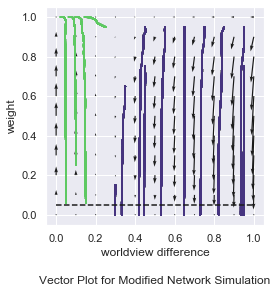

In [14]:
alpha = 0.01
beta = 0.3
gamma = 4

cmap = plt.cm.viridis  # color map to use

# Plot traces of how opinion and weight change over time
for worldview, weight in [
    [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
    [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
    [0.95, 0.35], [0.1, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
]:
    ow = [[worldview, 0.0, weight]]
    for i in range(100):
        # Choose a random number
        prob = random.random()
        if prob > 1/3:
            # If the number is bigger than 2/3, assume that the opinions
            # are not significant and draw them from the uniform distribution
            first_opinion = random.random()
            second_opinion = random.random()
            # Calculate the change in these two random opinions and a new weight
            delta_o = alpha * ow[-1][2] * (first_opinion - second_opinion)
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            # Update the worldview based on the opinions
            ow.append([ow[-1][0] + 0.1 *delta_o, ow[-1][1] - 0.1 *delta_o, new_weight])
        else:
            # Repeat the same for 
            first_opinion = random.uniform((ow[-1][1] -0.1), (ow[-1][1] +0.1))
            second_opinion = random.uniform((ow[-1][0] -0.1), (ow[-1][0] +0.1))
            delta_o = alpha * ow[-1][2] * (first_opinion - second_opinion)
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            ow.append([ow[-1][0] + 0.8 *delta_o, ow[-1][1] - 0.8 *delta_o, new_weight])
        plt.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

# Plot vector field
opinion = np.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
weight = np.linspace(0, 1, 11)   # the edge weight, w_ij
ow_grid = np.meshgrid(opinion, weight)
delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0]
delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

# Annotate plot
plt.xlabel('worldview difference')
plt.ylabel('weight')
plt.plot([0, 1], [0.05, 0.05], 'k--')
plt.axis('square')
plt.title("Vector Plot for Modified Network Simulation", y=-0.3)
plt.show()

# Implementation

## Choice of Random Graph

The Wattz-Strogatz graph replicates the small-world properties that closely model real-life social dynamics. It is initialized in a way that every node is connected to its closest neighbors. As a result, all the nodes have the same number of edges, and the probability of changing any of them is the same. It also exhibits small-world properties as there is a power-law distribution of number of edges per node since "hub" nodes with manyconnections tend to collect even more connections given preferential attachment.


In [15]:
class ModSocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.01, beta=0.9, gamma=4, prob_new = 0.02):
        '''
        Inputs:

            network_size (int) The number of nodes in the network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
              
            prob_new (float) The pobability of forming a new edge during each update.
            Default: 0.02
            
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.prob_new = prob_new
   
    def initialize(self):
        '''
        Initialize the simulation with a random graph. Initial edge weights are 0.5. 
        Each node has a set of three opinions which are randomly initialized to be 
        either 1 or 0. Opinions form the worldview and unequal importance with one
        opinion being the most formational. This opinion is defined by the "importance"
        attribute which is chosen randomly. Each node also has different level of 
        persuasiveness which is sampled from the normal distribution. 
        '''
        
        self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
         
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = np.random.uniform(0.3, 0.7)
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinions'] = [float(random.randint(0, 1)) for i in range(3)]
            self.graph.nodes[node]['importance'] = random.randint(0,2)
            opinions = self.graph.nodes[node]['opinions']
            importance = self.graph.nodes[node]['importance']
            self.graph.nodes[node]['worldview'] = opinions[importance] * 0.8
            + 0.1 * opinions[(importance+1)%3] + 0.1 * opinions[(importance+2)%3]
            #print self.graph.nodes[node]['worldview']
            self.graph.nodes[node]['persuasiveness'] = np.random.normal(0.5, 0.3)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0
        
    def observe(self):
        '''
        Draw the state of the network where the labels illustrate the worldview.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        node_labels = {}
        for node in self.graph.nodes:
            n_label = float(self.graph.nodes[node]['worldview']*100)
            node_labels[node] = int(n_label)
        nx.draw(
            self.graph, pos=self.layout, with_labels=False,
            node_color=[self.graph.nodes[i]['worldview'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        nx.draw_networkx_labels(self.graph, self.layout, node_labels)
        plt.title('Step: ' + str(self.step))
        
    def update(self):
        """
        Adds new connections according to the following rules:
        With a probability prob_new, find two nodes that are not connected.
        Check for the mutual connections. Nodes that have friends in common
        are more likely to meet, so they'll form a connection with a probability prob_new.
        The weight of the edge is determined as the average of all mutual connections.
        If these people don't have any mutual connections, the probability
        decreases to 0.1 * prob_new. The weight is chosen randomly from the uniform
        distribution in the range from 0.3 to 0.7
        
        Updates existing connections:
        Chooses two nodes and a topic randomly.
        Updates their opinions using the persuasiveness parameter.
        Updates the edge weight based on the new worldview.
        Removes week edges
        """
        if random.random() < self.prob_new:
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            # Two nodes without an edge are identified, now we need to check for mutual connections.
            edges = []
            if len(list(nx.common_neighbors(self.graph, new_edge[0], new_edge[1]))) > 0:
                # In case there are mutual connections, we simply add the edge
                for mutual_node in list(nx.common_neighbors(self.graph, new_edge[0], new_edge[1])):
                    for node in [new_edge[0], new_edge[1]]:
                         edges.append(self.graph.edges[mutual_node, node]['weight'])
                #print edges
                weight = np.mean(edges)
                self.graph.add_edge(new_edge[0], new_edge[1], weight=weight)
            else:
                # Otherwise, the edge is formed with a probability 0.1
                if random.uniform(0, 1) < 0.5:
                    weight = np.random.uniform(0.3,0.7)
                    self.graph.add_edge(new_edge[0], new_edge[1], weight = weight)      
    
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinions'] for n in edge]
            for i in [0, 1]:
                topic = random.randint(0,2)
                new_opinion = self.alpha * weight * (opinions[1-i][topic] - opinions[i][topic])
                self.graph.nodes[edge[i]]['opinions'][topic] = opinions[i][topic] + new_opinion + self.graph.nodes[edge[1-i]]['persuasiveness'] *0.1*new_opinion
                opinion = self.graph.nodes[edge[i]]['opinions']
                imp = self.graph.nodes[edge[i]]['importance']
                self.graph.nodes[edge[i]]['worldview'] = opinion[imp] * 0.8 + 0.1 * opinion[(imp+1)%3] + 0.1 * opinion[(imp+2)%3]
            first_worldview = self.graph.nodes[edge[0]]['worldview']
            second_worldview = self.graph.nodes[edge[1]]['worldview']
            self.graph.edges[edge]['weight'] = (weight + self.beta * weight * (1-weight) * (1 - self.gamma * abs(first_worldview - second_worldview)))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1
        

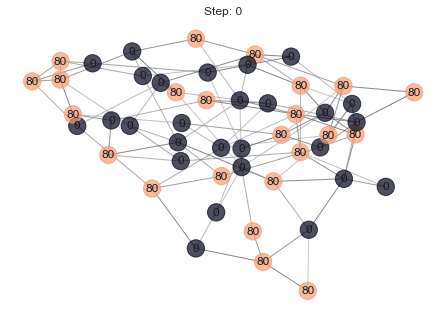

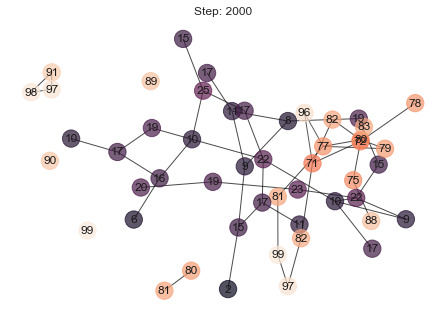

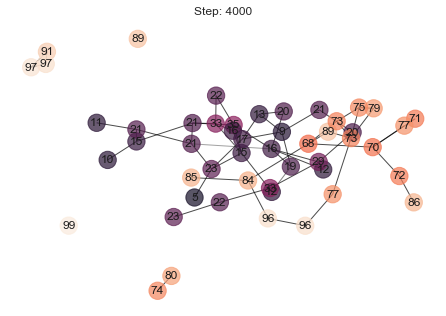

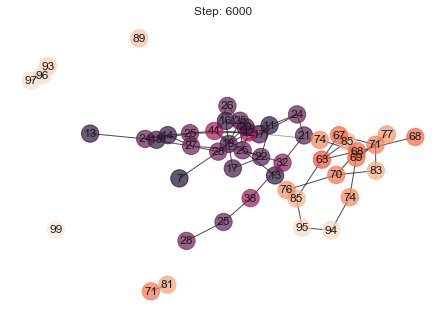

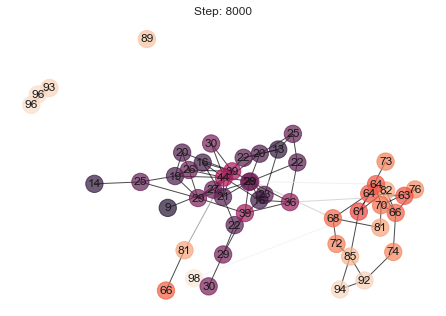

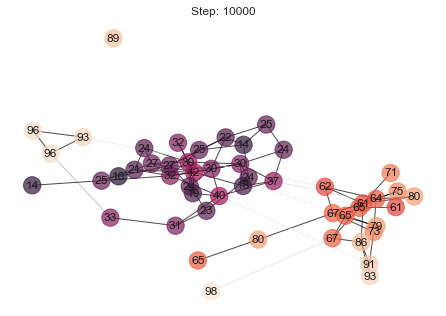

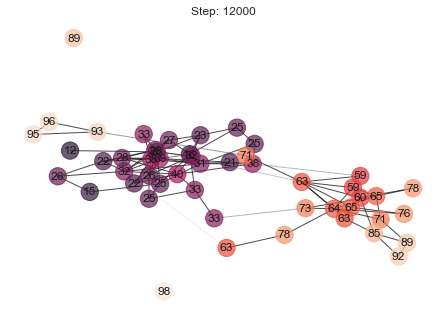

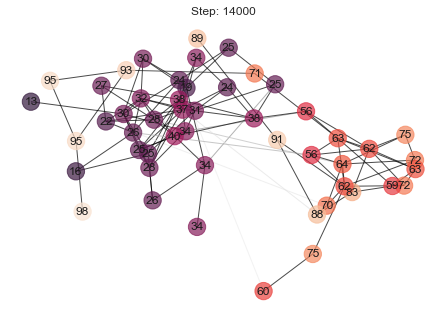

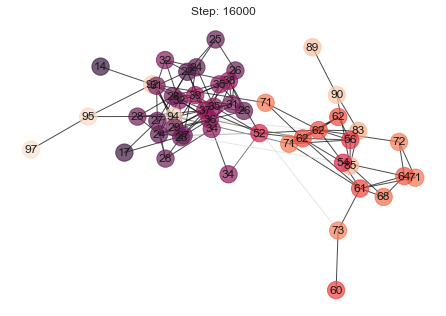

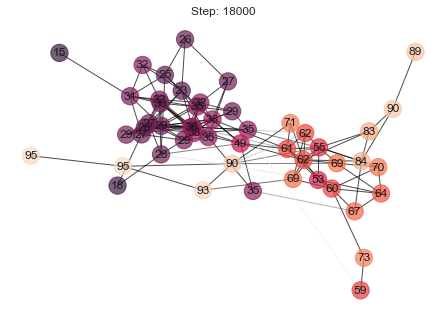

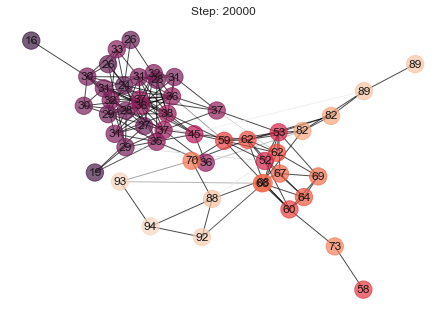

In [16]:
sim = ModSocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()
    plt.show()

# Simulation
I ran the simulation with low, optimal, and high values of parameters alpha, beta, and gamma on both graphs while holding the other parameters constant.

In [17]:
alphas = [0.001,0.01, 0.03]
betas = [0.01,0.3, 0.99]
gammas = [0.5,4,8]

## Change in Alpha
The simulation output is similar to the predicted results where low alpha results in a split of the network, and high alpha leads to the convergence of the worldviews. The moderate value needs more steps to either converge or split, and the result can be different.

Alpha = 0.001


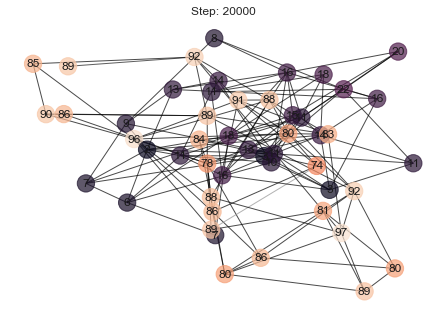

Alpha = 0.01


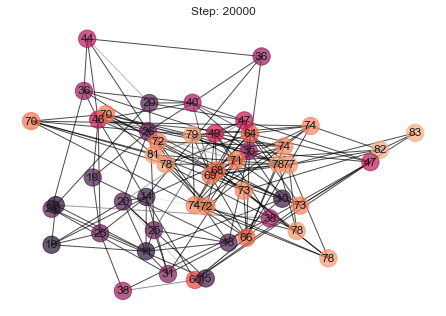

Alpha = 0.03


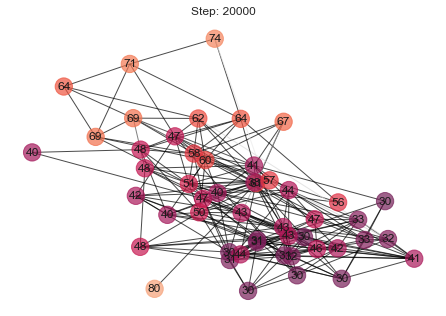

In [18]:
for alpha in alphas:
    sim = ModSocialDynamicsSimulation(alpha=alpha)
    sim.initialize()
    for i in range(20000):
        sim.update()
    plt.figure()
    sim.observe()
    print("Alpha =",alpha)
    plt.show()

## Change in Beta
One important observation is that the number of edges is much bigger for lower values of $\beta$ which is, of course, not very realistic. For high values, I expected to have a formation of clusters. However, it didn’t really happen since I haven’t account for the fact that the edge is removed before the nodes manage to converge. The optimal value has a reasonable number of edges so that the nodes can interact with each other a reasonable amount of time while still leaving a possibility for an edge to break.

Beta = 0.01


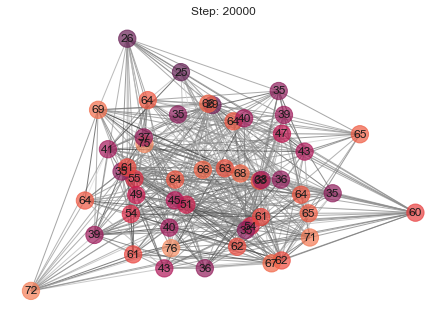

Beta = 0.3


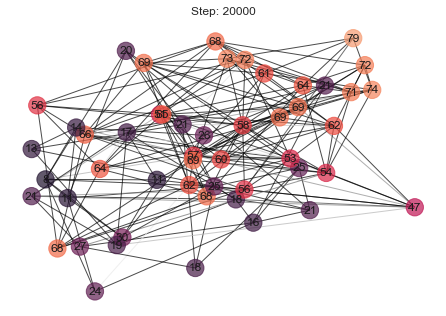

Beta = 0.99


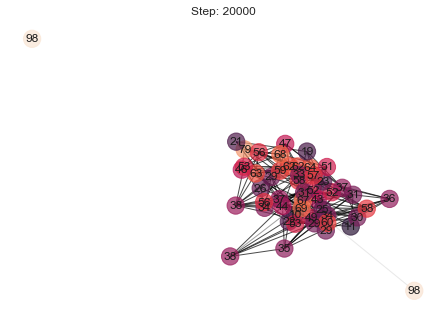

In [19]:
for beta in betas:
    sim = ModSocialDynamicsSimulation(beta=beta)
    sim.initialize()
    for i in range(20000):
        sim.update()
    plt.figure()
    sim.observe()
    print("Beta =",beta)
    plt.show()

## Change in Gamma
In the last experiment, I used different values of gammas. As expected, the network never splits and never loses edges if $\gamma$ is very small, so the network converged. For a high value, the distribution of the worldviews looks pretty random which can be explained by the fact that the nodes split too fast without actually adjusting their worldviews. 

Gamma = 0.5


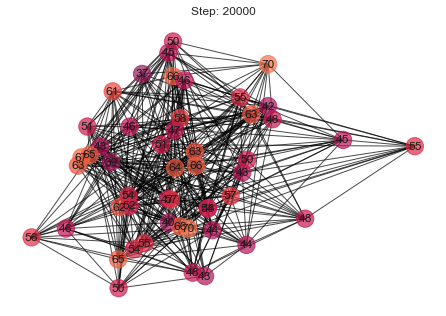

Gamma = 4


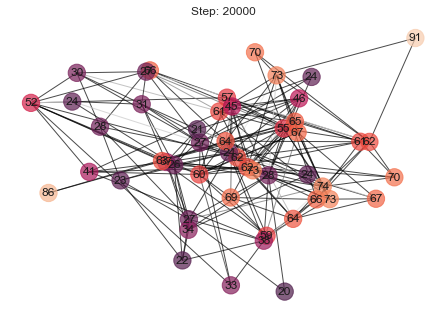

Gamma = 8


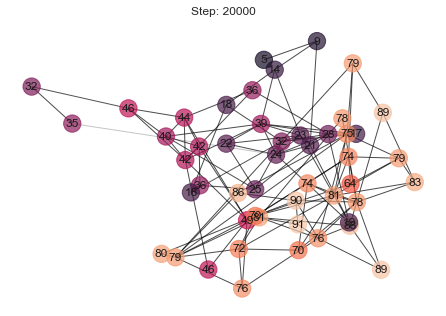

In [20]:
for gamma in gammas:
    sim = ModSocialDynamicsSimulation(gamma=gamma)
    sim.initialize()
    for i in range(20000):
        sim.update()
    plt.figure()
    sim.observe()
    print("Gamma =",gamma)
    plt.show()

# Possible Extensions

1.  Assigning different probabilities for the topic to be chosen in the interaction. This is because some topics come up more regularly in conversation than others. 

2.  Initializing the simulation with a different random graph. For example, looking at how allowing for growth of nodes using the Barbasi Albert graph would affect the rate of convergence

By adding more complexity to the model, we could technically make the model more similar to real life, but this might also take away the appeal of the model as a simple simulation that can represent the complexity of real life without trying to include all the minute details. A careful consideration has to be made regarding the use-case of the model before additional modifications are added for the sake of making the model more "realistic"


# HCs Used

## #modelling

In this assignment, I effectively developed a social dynamics simulation model in order to simulate the various scenarios given in the assignment instructions and provided clear, detailed explanations for all of them. I also accurately interprets and clearly explains the results of the model and how that relates to a real-life context.

## #networks
In this assignment, I analyzed the network structure of the social dynamics simulation model that I created in relation to the different scenarios at hand. I also used network analysis to propose effective interventions within a system by relating it back to a real-world context and see how the various scenarios that I created could model something that could happen in real life.

## #distributions
By drawing the persuasiveness parameter from a normal distribution, we expect most people to be moderately persuasive, with only a few people having higher than normal charisma thus being better at persuading other people; and vive versa. This, we have a lower probability of sampling it from the tail ends of the normal distribution. 